In [1]:
!pip install svetlanna
!pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import wavefront as w
from svetlanna.units import ureg

# Пример дифракции на тонкой щели
В этом примере будет численно решена прямая задача дифракции плоской волны на тонкой щели с использованием прямоугольной апертуры из модуля `svetlanna.elements` 

## Создание расчетной сетки с использованием класса `SimulationParameters`

In [3]:
D = 0.1 * ureg.mm   # ширина щели
d = 0.5 * ureg.mm   # высота щели

wavelength = 660 * ureg.nm  # длина волны

lx = 4 * ureg.mm  # ширина экрана
ly = 4 * ureg.mm  # высота экрана

# расстояние от щели до экрана
z = 3 * ureg.cm

# количество точек в расчетной сетке
Nx = 1600
Ny = 1600

sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})

In [4]:
x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Создание плоской волны с использованием `svetlanna.wavefront.plane_wave`

Создадим плоскую волну, которая будет падать на щель:

In [5]:
incident_field = w.Wavefront.plane_wave(
    simulation_parameters=sim_params,
    distance=0 * ureg.cm,
    wave_direction=[0, 0, 1]
)

## Создание тонкой щели с использованием класса`svetlanna.elements.RectangularAperture`

In [6]:
slit = elements.RectangularAperture(
    simulation_parameters=sim_params,
    height=d,
    width=D,
)

Продемонстрируем форму апертуры, используя метод класса `.get_transmission_function()`:

In [7]:
slit_transmission_function = slit.get_transmission_function()

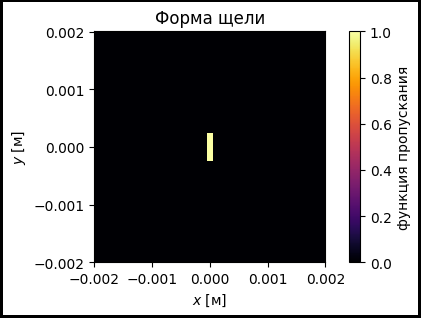

In [8]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, slit_transmission_function, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Форма щели')
ax.set_xlabel('$x$ [м]')
ax.set_ylabel('$y$ [м]')
fig.colorbar(im1, label='функция пропускания')

## Распределение интенсивности после прохождения плоской волны через тонкую щель

В этой секции будет решена прямая задача дифракции плоской волны на тонкой щели с использованием метода углового спектра из класса `FreeSpace`

In [9]:
field_after_slit = slit.forward(
    incident_wavefront=incident_field
)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=z,
    method="AS"
)

output_wavefront = free_space.forward(
    incident_wavefront=field_after_slit
)

output_intensity = output_wavefront.intensity

Визуализируем распределение интенсивности на экране:

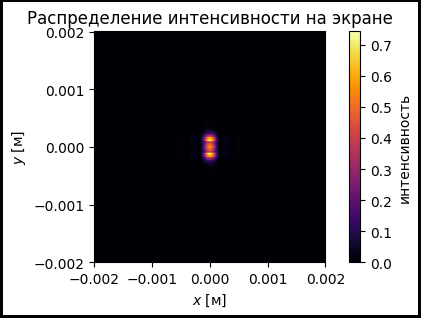

In [10]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, output_intensity, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Распределение интенсивности на экране')
ax.set_xlabel('$x$ [м]')
ax.set_ylabel('$y$ [м]')
fig.colorbar(im1, label='интенсивность')

# Сравнение с уравнением дифракционной решетки

Используя уравнение дифракционной решетки $D \sin{\theta}=m\lambda$, где  m - порядок дифракции, найдем положение минимумов интенсивности

In [11]:
# массив порядков дифракции
m  = np.arange(1,8,1)
x_min = np.sqrt(m**2 * wavelength**2 * z**2 / (D**2 - m**2 * wavelength**2))

Text(0, 0.5, 'амплитуда')

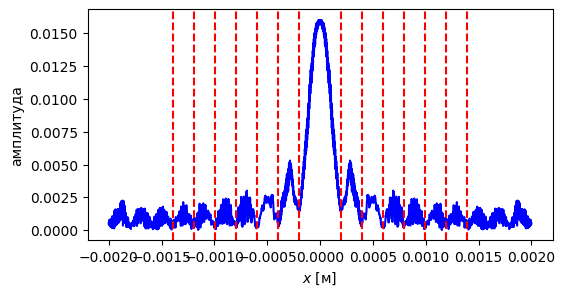

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x_grid[0], torch.sqrt(output_intensity)[250], color='blue')

[ax.axvline(x, ls='--', color='r') for x in x_min]
[ax.axvline(-x, ls='--', color='r') for x in x_min]

ax.set_xlabel('$x$ [м]')
ax.set_ylabel('амплитуда')
